In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, BatchSampler, RandomSampler
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [31]:
# arguments
batch_size = 64
test_batch_size = 1000
epochs = 20
device = 'cuda'

# model class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.BN16 = nn.BatchNorm2d(16)
        self.BN32 = nn.BatchNorm2d(32)
        self.BN64 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*14*14, 32)
        self.fc2 = nn.Linear(32, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN16(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.BN32(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.BN64(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output


# train function
def train(data_loader, model, optimizer):
    model.train()
    total_batchs = len(data_loader)
    train_loss = 0
    equal = '='
    arrow = '>'
    hyphen = '-'
    for batch, (data, label) in enumerate(data_loader):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = F.cross_entropy(pred, label)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bar_num = int(20 * ((batch+1) / total_batchs))
        print(f'[{bar_num*equal + arrow + (20-bar_num)*hyphen}]\tTraining Loss: {train_loss/(batch+1):.4f}', end='\r')
    print()
        
# test function
def evaluate(data_loader, model, mode='eval'):
    model.eval()
    total_batchs = len(data_loader)
    data_size = len(data_loader.dataset)
    eval_loss, correct = 0, 0
    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            pred = model(data)
            eval_loss += F.cross_entropy(pred, label, reduction = 'sum').item()
            correct += (pred.argmax(dim=1) == label).type(torch.float).sum().item()
    eval_loss /= data_size
    correct /= data_size
    if mode == 'eval':
        print(f'\t\tValidation Loss: {eval_loss:.4f}\tValidation Accuracy: {100*correct:.1f}%')
    elif mode == 'test':
        print(f'\t\tTest Loss: {eval_loss:.4f}\tTest Accuracy: {100*correct:.1f}%\n')


# transform
train_tr = T.Compose([
    T.ToTensor()
])
eval_tr = T.Compose([
    T.ToTensor()
])

# load data
train_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    transform=train_tr
)
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    transform=eval_tr
)

(val_data, test_data) = random_split(test_data, [5000, 5000])

# data loader
train_loader = DataLoader(train_data, batch_sampler=BatchSampler(RandomSampler(train_data), batch_size=batch_size, drop_last=False))
val_loader = DataLoader(val_data, batch_sampler=BatchSampler(RandomSampler(val_data), batch_size=test_batch_size, drop_last=False))
test_loader = DataLoader(test_data, batch_sampler=BatchSampler(RandomSampler(test_data), batch_size=test_batch_size, drop_last=False))

In [32]:
# build model
model = Net().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    train(train_loader, model, optimizer)
    evaluate(val_loader, model, 'eval')
    
    

Epoch 1:
[====================>]	Training Loss: 0.89687
		Validation Loss: 0.3242	Validation Accuracy: 88.5%
Epoch 2:
[====================>]	Training Loss: 0.2805
		Validation Loss: 0.3019	Validation Accuracy: 88.9%
Epoch 3:
[====================>]	Training Loss: 0.2393
		Validation Loss: 0.2778	Validation Accuracy: 89.8%
Epoch 4:
[====================>]	Training Loss: 0.2231
		Validation Loss: 0.2547	Validation Accuracy: 90.8%
Epoch 5:
[====================>]	Training Loss: 0.2106
		Validation Loss: 0.3105	Validation Accuracy: 89.5%
Epoch 6:
[====================>]	Training Loss: 0.2020
		Validation Loss: 0.3213	Validation Accuracy: 88.4%
Epoch 7:
[====================>]	Training Loss: 0.1982
		Validation Loss: 0.3058	Validation Accuracy: 90.3%
Epoch 8:
[====================>]	Training Loss: 0.1874
		Validation Loss: 0.2855	Validation Accuracy: 90.5%
Epoch 9:
[====================>]	Training Loss: 0.1743
		Validation Loss: 0.2975	Validation Accuracy: 90.1%
Epoch 10:
[================

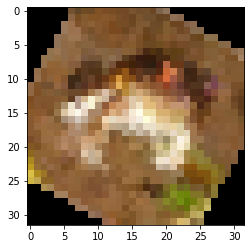

In [65]:
plt.imshow(np.moveaxis(np.array(T.functional.rotate(train_data[0][0], -30)), 0, 2))

In [60]:
np.moveaxis(np.array(train_data[0][0]), 0, 2).shape

(32, 32, 3)

In [2]:
torch.cuda.current_device()

0

In [25]:
train_data[0][0].shape

torch.Size([1, 28, 28])